In [1]:
import torch
import torch.nn as nn
from torch.utils.data.dataloader import DataLoader
from torch.optim.adam import Adam
from torchvision.datasets.cifar import CIFAR10
from torchvision.transforms import Compose
from torchvision.transforms import RandomCrop, RandomHorizontalFlip, Normalize
import torchvision.transforms as T

In [ ]:
transforms = Compose([
    RandomCrop((32, 32), padding= 4),
    RandomHorizontalFlip(p= 0.5),
    T.ToTensor(),
    Normalize(mean= (0.4914, 0.4822, 0.4465), std= (0.247, 0.243, 0.261))
])

train_data = CIFAR10(root='files/', train= True, download= True, transform= transforms)
test_data = CIFAR10(root='files/', train= False, download= True, transform= transforms)

In [3]:
train_loader = DataLoader(train_data, batch_size= 32, shuffle= True)
test_loader = DataLoader(test_data, batch_size= 32, shuffle= False)

In [4]:
img_data = iter(train_loader)
images, labels = next(img_data)

images.shape

torch.Size([32, 3, 32, 32])

In [5]:
img_data = images[7]

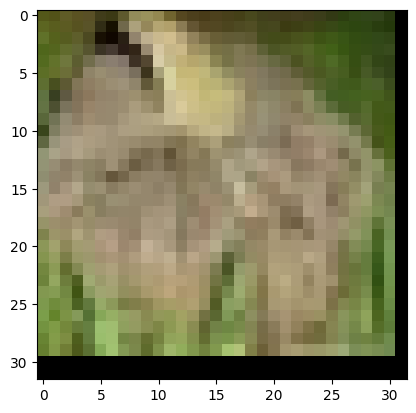

In [6]:
import matplotlib.pyplot as plt
import numpy as np

def denomalize(img, mean, std):
    mean = torch.tensor(mean).view(3, 1, 1)
    std = torch.tensor(std).view(3, 1, 1)
    return img * std + mean

def View_img(image):
    mean= (0.4914, 0.4822, 0.4465) 
    std= (0.247, 0.243, 0.261)

    img_data = denomalize(image, mean, std)
    # img_data = image            # 자료형이 tensor이기 때문에
    img_data = img_data.numpy()     # 자료형을 전달하기 위해서는 numpy로 바꿔줘야 한다.
    plt.imshow(np.transpose(img_data,(1, 2, 0)))
    plt.show()


View_img(images[11])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.9894737..1.9253625].


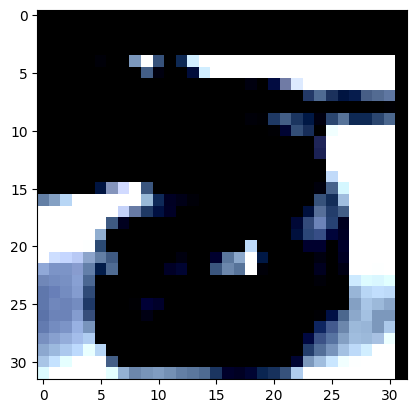

In [7]:
import matplotlib.pyplot as plt
import numpy as np

plt.imshow(np.transpose(img_data,(1, 2, 0)))
plt.show()

In [8]:
class BasicBlock(nn.Module):
    def __init__(self, in_channels, out_channels, hidden_dim):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, hidden_dim, kernel_size= 3, padding= 1)
        self.conv2 = nn.Conv2d(hidden_dim, out_channels, kernel_size= 3, padding= 1)
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool2d(kernel_size= 2, stride= 2)

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.relu(x)
        x = self.pool(x)

        return x
    
class Vgg16(nn.Module):
    def __init__(self, num_classes):
        super(Vgg16, self).__init__()

        self.block1 = BasicBlock(in_channels= 3, out_channels= 32, hidden_dim= 16)      # 32 -> 16. output : 16
        self.block2 = BasicBlock(in_channels= 32, out_channels= 128, hidden_dim= 64)    # 16 -> 8. output : 8
        self.block3 = BasicBlock(in_channels= 128, out_channels= 256, hidden_dim= 128)  # 8 -> 4. output : 4
        # 256 * 4 * 4

        self.fc1 = nn.Linear(in_features= 256 * 4 * 4, out_features= 2048)      # out_features는 임의로 지정하나 2의 승수로 작성하는 게 좋다
        self.fc2 = nn.Linear(in_features= 2048, out_features= 256)
        self.fc3 = nn.Linear(in_features= 256, out_features= num_classes)

        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)

        x = torch.flatten(x, start_dim= 1)      # metrix를 1차원으로 펴는 작업. 기존은 view와 reshape을 사용했음.
        # x = x.view(-1)

        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.fc3(x)

        return x

model = Vgg16(10)
model


Vgg16(
  (block1): BasicBlock(
    (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu): ReLU()
    (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block2): BasicBlock(
    (conv1): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu): ReLU()
    (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block3): BasicBlock(
    (conv1): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv2): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu): ReLU()
    (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Linear(in_features=4096, out_features=2048, bias=True)
  (fc2): Linear(in_features=2048, out_features=25

In [9]:
from torch.utils.tensorboard import SummaryWriter
import tqdm

writer = SummaryWriter()
lr = 1e-3
optim = Adam(model.parameters(), lr= lr)
criterion = nn.CrossEntropyLoss()
epochs = 20

device = 'cuda' if torch.cuda.is_available else 'cpu'
model.to(device)

step = 0

for epoch in range(epochs):
    for data, label in tqdm.tqdm(train_loader):
        optim.zero_grad()

        preds = model(data.to(device))
        loss = criterion(preds, label.to(device))

        loss.backward()
        optim.step()

        writer.add_scalar('loss/train', loss.item(), step)
        step += 1

    print(f'{epoch} loss: {loss.item()}')

100%|██████████| 1563/1563 [00:22<00:00, 68.85it/s]


0 loss: 1.3071599006652832


100%|██████████| 1563/1563 [00:23<00:00, 67.74it/s]


1 loss: 0.8781338930130005


100%|██████████| 1563/1563 [00:23<00:00, 66.72it/s]


2 loss: 0.8294076919555664


100%|██████████| 1563/1563 [00:23<00:00, 67.88it/s]


3 loss: 0.7773556709289551


100%|██████████| 1563/1563 [00:22<00:00, 68.35it/s]


4 loss: 0.9769259691238403


100%|██████████| 1563/1563 [00:22<00:00, 68.00it/s]


5 loss: 0.17685666680335999


100%|██████████| 1563/1563 [00:23<00:00, 67.79it/s]


6 loss: 0.6744651794433594


100%|██████████| 1563/1563 [00:23<00:00, 65.35it/s]


7 loss: 0.8116651177406311


100%|██████████| 1563/1563 [00:24<00:00, 64.46it/s]


8 loss: 0.6747044324874878


100%|██████████| 1563/1563 [00:24<00:00, 64.39it/s]


9 loss: 0.660763680934906


100%|██████████| 1563/1563 [00:24<00:00, 63.98it/s]


10 loss: 0.247442364692688


100%|██████████| 1563/1563 [00:27<00:00, 56.58it/s]


11 loss: 0.45084142684936523


100%|██████████| 1563/1563 [00:25<00:00, 61.29it/s]


12 loss: 0.8539729118347168


100%|██████████| 1563/1563 [00:24<00:00, 63.28it/s]


13 loss: 0.7508182525634766


100%|██████████| 1563/1563 [00:24<00:00, 63.41it/s]


14 loss: 0.4048181176185608


100%|██████████| 1563/1563 [00:24<00:00, 63.16it/s]


15 loss: 0.6139569282531738


100%|██████████| 1563/1563 [00:24<00:00, 62.65it/s]


16 loss: 0.08410238474607468


100%|██████████| 1563/1563 [00:24<00:00, 63.51it/s]


17 loss: 0.28221532702445984


100%|██████████| 1563/1563 [00:24<00:00, 63.48it/s]


18 loss: 0.4756562113761902


100%|██████████| 1563/1563 [00:24<00:00, 63.34it/s]

19 loss: 0.5716896653175354


In [10]:
model.eval()

with torch.no_grad():
    total_corr = 0
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        preds = model(images)
        _, pred = torch.max(preds.data, 1)
        total_corr += (pred == labels).sum().item()

    print(f'정확도: {total_corr/len(test_data.targets)}')

정확도: 0.792


In [11]:
from torchvision.models.vgg import vgg19

model = vgg19(pretrained= True)
model

c:\DL\.venv\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\DL\.venv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padd

In [12]:
fc = nn.Sequential(
    nn.Linear(25088, 4096),
    nn.ReLU(),
    nn.Dropout(),
    nn.Linear(4096, 4096),
    nn.ReLU(),
    nn.Dropout(),
    nn.Linear(4096, 10)
)

model.classifier = fc
model

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padd